<a href="https://colab.research.google.com/github/piiop/final_project/blob/main/cnn_model_training_curated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard libraries
import os
import math
import pickle
import shutil
import io

# Data manipulation and analysis
import numpy as np
import pandas as pd
from tqdm import tqdm

# Image processing
from PIL import Image

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import the preprocessed data
imgs = pd.read_csv("/content/training_imageset_curated.csv")

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movement   15600 non-null  object
 1   file_path  15600 non-null  object
dtypes: object(2)
memory usage: 243.9+ KB


In [ ]:
imgs['file_path'].head()

,file_path
0,resized_imgs_curated\57728a68edc2cb388010fa7e.jpg
1,resized_imgs_curated\57728a68edc2cb388010fa90.jpg
2,resized_imgs_curated\57728a69edc2cb388010faa0.jpg
3,resized_imgs_curated\57728a69edc2cb388010fab0.jpg
4,resized_imgs_curated\57728a69edc2cb388010fac0.jpg


In [ ]:
def validate_file_paths(df, column='file_path'):
    """
    Validates file paths in a DataFrame column to check for entries not containing 'resized'.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the file paths
    column (str): Name of the column containing file paths

    Returns:
    tuple: (invalid_paths_df, valid_df)
        - invalid_paths_df: DataFrame containing rows where file paths don't contain 'resized'
        - valid_df: DataFrame with only valid file paths (with reset index)
    """
    # Find invalid paths
    mask = ~df[column].str.contains('resized', case=False, na=True)
    invalid_paths = df[mask].copy()

    # Create valid DataFrame and reset index
    valid_df = df[~mask].copy().reset_index(drop=True)

    # Print summary
    print(f"Total paths: {len(df)}")
    print(f"Invalid paths found: {len(invalid_paths)}")
    print(f"Valid paths: {len(valid_df)}")

    # Print index information
    print(f"\nValid DataFrame index range: {valid_df.index.min()} to {valid_df.index.max()}")
    print(f"Index is continuous: {valid_df.index.is_monotonic_increasing}")

    return invalid_paths, valid_df

# Use the updated function
invalid_paths, imgs = validate_file_paths(imgs, 'file_path')

Total paths: 15600
Invalid paths found: 0
Valid paths: 15600

Valid DataFrame index range: 0 to 15599
Index is continuous: True


In [ ]:
imgs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15600 entries, 0 to 15599
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movement   15600 non-null  object
 1   file_path  15600 non-null  object
dtypes: object(2)
memory usage: 243.9+ KB


Load the files from Google Drive into Colab runtime

In [ ]:
def load_files_to_colab(df, dest_base_path='/content/local_images/'):
    """
    Copy files from Google Drive to Colab runtime directory and update DataFrame with local paths.

    Args:
        df: DataFrame containing original file paths
        dest_base_path: Base path for local storage in Colab

    Returns:
        DataFrame with new column containing local file paths
    """
    os.makedirs(dest_base_path, exist_ok=True)

    # Create a copy of the DataFrame to avoid modifying the original
    df_local = df.copy()

    # Add new column for local paths
    df_local['local_path'] = ''

    for idx, row in tqdm(df_local.iterrows(), total=len(df_local), desc="Copying files"):
        relative_path = row['file_path'].replace('\\', '/')
        file_name = relative_path.split('/')[-1]
        source_path = f'/content/drive/MyDrive/art_classification/{relative_path}'
        dest_path = os.path.join(dest_base_path, file_name)

        # Copy file if it doesn't already exist
        if not os.path.exists(dest_path):
            shutil.copy2(source_path, dest_path)

        # Update DataFrame with local path
        df_local.at[idx, 'local_path'] = dest_path

    return df_local

# Update your DataFrame with local paths
imgs_local = load_files_to_colab(imgs)

Copying files: 100%|██████████| 15600/15600 [3:32:49<00:00,  1.22it/s]


Convert the image files to floating point numpy arrays and normalize. And load the into the dataframe in batches for training.

In [ ]:
# Convert to floating point and normalize
def load_and_normalize_image(file_path):
    """
    Load image from file_path, convert to float32 array and normalize to [0, 1] range

    Args:
        file_path (str): Path to the image file

    Returns:
        numpy.ndarray: Normalized image array of shape (height, width, 3) in float32
    """
    # Load image
    img = Image.open(file_path)

    # Convert to RGB if not already
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Convert to numpy array and change type to float32
    img_array = np.array(img, dtype=np.float32)

    # Normalize to [0, 1] range
    img_array = img_array / 255.0

    return img_array

import time

def load_images_in_batches(dataframe, batch_size=1000):
    """Load images in batches with timing information"""
    total_batches = (len(dataframe) // batch_size) + 1
    all_arrays = []

    for i in range(0, len(dataframe), batch_size):
        batch_start_time = time.time()
        batch = dataframe.iloc[i:i+batch_size]
        batch_arrays = []

        print(f"\nProcessing batch {i//batch_size + 1}/{total_batches}")

        for idx, file_path in enumerate(batch['local_path']):
            start_time = time.time()
            try:
                img_array = load_and_normalize_image(file_path)
                batch_arrays.append(img_array)
                load_time = time.time() - start_time
                if load_time > 1.0:  # Log slow loads
                    print(f"\nSlow load ({load_time:.2f}s): {file_path}")
            except Exception as e:
                print(f"\nError processing {file_path}: {str(e)}")
                continue

            if idx % 10 == 0:
                print(f"Progress: {idx}/{len(batch)}", end='\r')

        all_arrays.extend(batch_arrays)
        batch_time = time.time() - batch_start_time
        print(f"\nBatch {i//batch_size + 1} completed in {batch_time:.2f} seconds")
        print(f"Average time per image: {batch_time/len(batch):.2f} seconds")

    return np.array(all_arrays)

# Load images using updated DataFrame
image_arrays = load_images_in_batches(imgs_local, batch_size=1000)


Processing batch 1/16
Progress: 990/1000
Batch 1 completed in 1.43 seconds
Average time per image: 0.00 seconds

Processing batch 2/16
Progress: 990/1000
Batch 2 completed in 1.38 seconds
Average time per image: 0.00 seconds

Processing batch 3/16
Progress: 990/1000
Batch 3 completed in 1.39 seconds
Average time per image: 0.00 seconds

Processing batch 4/16
Progress: 990/1000
Batch 4 completed in 1.35 seconds
Average time per image: 0.00 seconds

Processing batch 5/16
Progress: 990/1000
Batch 5 completed in 1.37 seconds
Average time per image: 0.00 seconds

Processing batch 6/16
Progress: 990/1000
Batch 6 completed in 1.40 seconds
Average time per image: 0.00 seconds

Processing batch 7/16
Progress: 990/1000
Batch 7 completed in 1.38 seconds
Average time per image: 0.00 seconds

Processing batch 8/16
Progress: 990/1000
Batch 8 completed in 1.39 seconds
Average time per image: 0.00 seconds

Processing batch 9/16
Progress: 990/1000
Batch 9 completed in 1.23 seconds
Average time per ima

In [ ]:
# Define X and y
X = image_arrays
y = imgs_local['movement']

In [ ]:
# Check current state
print("X shape:", X.shape)
print("y length:", len(y))
print("y index range:", y.index.min(), "to", y.index.max())

# Check if y has any gaps in its index
print("\nNumber of gaps in y index:", len(set(range(y.index.min(), y.index.max() + 1)) - set(y.index)))

# Print a few samples showing X and y alignment
print("\nSample alignment check:")
for i in range(5):
    print(f"Index {i}:")
    print(f"X shape: {X[i].shape}")
    print(f"y label: {y.iloc[i]}")
    print("---")

X shape: (15600, 256, 256, 3)
y length: 15600
y index range: 0 to 15599

Number of gaps in y index: 0

Sample alignment check:
Index 0:
X shape: (256, 256, 3)
y label: naive_art
---
Index 1:
X shape: (256, 256, 3)
y label: naive_art
---
Index 2:
X shape: (256, 256, 3)
y label: naive_art
---
Index 3:
X shape: (256, 256, 3)
y label: naive_art
---
Index 4:
X shape: (256, 256, 3)
y label: naive_art
---


In [ ]:
# Get our list of styles in order
unique_styles = imgs_local['movement'].unique()
print("Style order:")
for i, style in enumerate(unique_styles):
    print(f"{i}: {style}")

Style order:
0: naive_art
1: baroque
2: rococo
3: romanticism
4: art_deco
5: american_realism
6: art_nouveau
7: expressionism
8: modernism
9: post_impressionism
10: high_renaissance
11: cubism
12: abstract_expressionism
13: art_informel
14: mannerism
15: northern_renaissance
16: surrealism
17: symbolism
18: early_renaissance
19: neo_romantic
20: ukiyo_e
21: impressionism
22: pop_art
23: fauvism
24: neoclassicism
25: minimalism


In [ ]:
# Split the training dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=99)

In [ ]:
# First convert strings to numbers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Then one-hot using tensorflows method
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

print("y_train_cat shape:", y_train_cat.shape)
print("y_test_cat shape:", y_test_cat.shape)

y_train_cat shape: (11700, 26)
y_test_cat shape: (3900, 26)


In [ ]:
# Convert list/series of arrays into a single 4D tensor
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (11700, 256, 256, 3)
X_test shape: (3900, 256, 256, 3)


In [ ]:
# Define SE block
def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    # Squeeze
    x = layers.GlobalAveragePooling2D()(input_tensor)

    # Excitation
    x = layers.Dense(channels // ratio, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)

    # Reshape to broadcasting shape
    x = layers.Reshape((1, 1, channels))(x)

    # Scale
    return layers.multiply([input_tensor, x])

# Define input layer
inputs = keras.Input(shape=(256, 256, 3))

# Define L2 regularizer
l2_reg = keras.regularizers.l2(0.0001)

# First Conv Block
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization()(x)
x = squeeze_excite_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

# Second Conv Block
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization()(x)
x = squeeze_excite_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.25)(x)

# Third Conv Block
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization()(x)
x = squeeze_excite_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Fourth Conv Block
x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization()(x)
x = squeeze_excite_block(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

# Dense layers
x = layers.Dense(256, activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(26, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Original learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    drop_rate = 0.5
    epochs_drop = 8.0
    lr = initial_lr * math.pow(drop_rate, math.floor(epoch/epochs_drop))
    return lr

# Add callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

# Compile the model with label smoothing
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=40,
    batch_size=64,
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 59s 227ms/step - accuracy: 0.0747 - loss: 3.8199 - val_accuracy: 0.0418 - val_loss: 3.5521 - learning_rate: 0.0010
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.1099 - loss: 3.4628 - val_accuracy: 0.0638 - val_loss: 3.4889 - learning_rate: 0.0010
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.1381 - loss: 3.2908 - val_accuracy: 0.1241 - val_loss: 3.3583 - learning_rate: 0.0010
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.1764 - loss: 3.1189 - val_accuracy: 0.1326 - val_loss: 3.3060 - learning_rate: 0.0010
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.2097 - loss: 3.0021 - val_accuracy: 0.2241 - val_loss: 2.9732 - learning_rate: 0.0010
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.2405 - loss: 2.8812 - val_accuracy: 0.1387 - val_loss: 3.3231 - learning_rate: 0.0010
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.2

In [ ]:
#Evaluate the model using the testing data
model.evaluate(X_test, y_test_cat)

122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.6541 - loss: 1.7911


[1.7942512035369873, 0.6505128145217896]

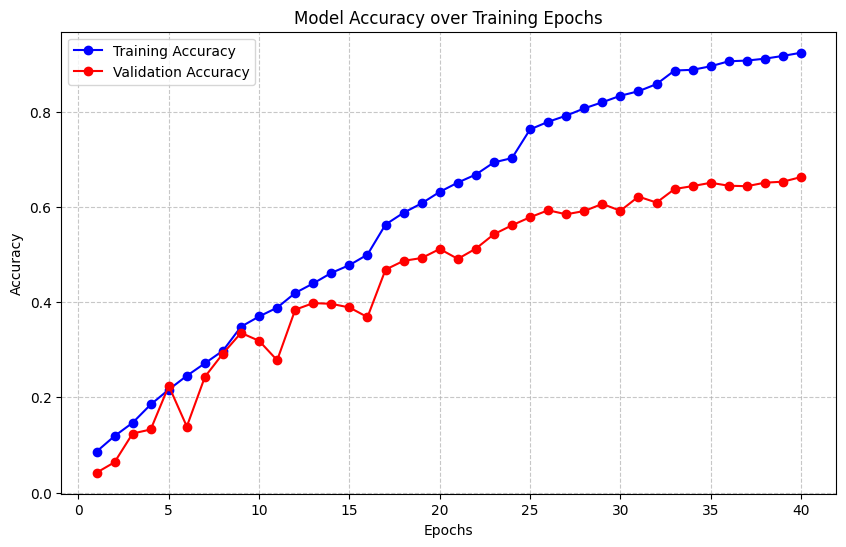

Final Training Accuracy: 0.9236
Final Validation Accuracy: 0.6626


In [ ]:
# Plot training history

# Get training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(acc) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')

plt.title('Model Accuracy over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Add horizontal and vertical gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Print final accuracies
print(f'Final Training Accuracy: {acc[-1]:.4f}')
print(f'Final Validation Accuracy: {val_acc[-1]:.4f}')

122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
Classification Report:
                        precision  recall  f1-score   support
naive_art                   0.564   0.673     0.614   150.000
baroque                     0.545   0.567     0.556   150.000
rococo                      0.972   0.913     0.942   150.000
romanticism                 0.536   0.640     0.584   150.000
art_deco                    0.791   0.707     0.746   150.000
american_realism            0.567   0.673     0.616   150.000
art_nouveau                 0.633   0.540     0.583   150.000
expressionism               0.662   0.653     0.658   150.000
modernism                   0.495   0.327     0.394   150.000
post_impressionism          0.754   0.673     0.711   150.000
high_renaissance            0.550   0.553     0.551   150.000
cubism                      0.570   0.567     0.569   150.000
abstract_expressionism      0.511   0.633     0.565   150.000
art_informel                0.703   0.727     0.715   150.000
manne

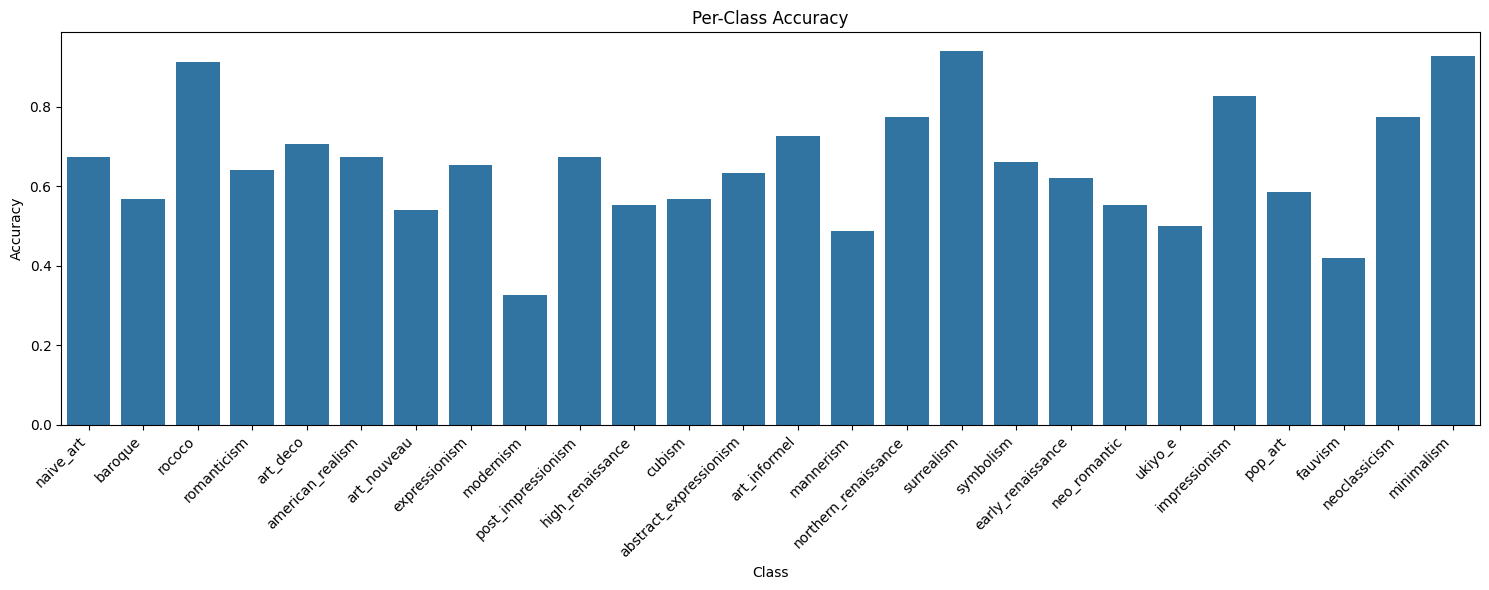


Top 10 Misclassifications:
1. True: naive_art → Predicted: art_informel (Count: 20)
2. True: cubism → Predicted: ukiyo_e (Count: 17)
3. True: abstract_expressionism → Predicted: high_renaissance (Count: 17)
4. True: art_nouveau → Predicted: mannerism (Count: 16)
5. True: art_informel → Predicted: naive_art (Count: 16)
6. True: american_realism → Predicted: abstract_expressionism (Count: 15)
7. True: high_renaissance → Predicted: american_realism (Count: 15)
8. True: high_renaissance → Predicted: early_renaissance (Count: 15)
9. True: romanticism → Predicted: naive_art (Count: 14)
10. True: modernism → Predicted: ukiyo_e (Count: 14)


In [ ]:
def evaluate_model_per_class(model, X_test, y_test_cat, class_names):
    """
    Evaluate model performance for each class with detailed metrics and visualizations.
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)_nm
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    print(report_df.round(3))

    # Calculate per-class accuracy
    cm = confusion_matrix(y_true, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # Plot per-class accuracy
    plt.figure(figsize=(15, 6))
    sns.barplot(x=class_names, y=per_class_accuracy)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Plot top misclassifications
    misclassification_matrix = cm.copy()
    np.fill_diagonal(misclassification_matrix, 0)
    top_misclassifications = []

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j:
                top_misclassifications.append({
                    'true': class_names[i],
                    'predicted': class_names[j],
                    'count': misclassification_matrix[i, j]
                })

    top_misclassifications.sort(key=lambda x: x['count'], reverse=True)

    # Print top 10 misclassifications
    print("\nTop 10 Misclassifications:")
    for i, misc in enumerate(top_misclassifications[:10]):
        print(f"{i+1}. True: {misc['true']} → Predicted: {misc['predicted']} "
              f"(Count: {misc['count']})")

    return report_df, cm, per_class_accuracy

# Run the evaluation
report_df, confusion_mat, class_accuracies = evaluate_model_per_class(
    model, X_test, y_test_cat, unique_styles
)

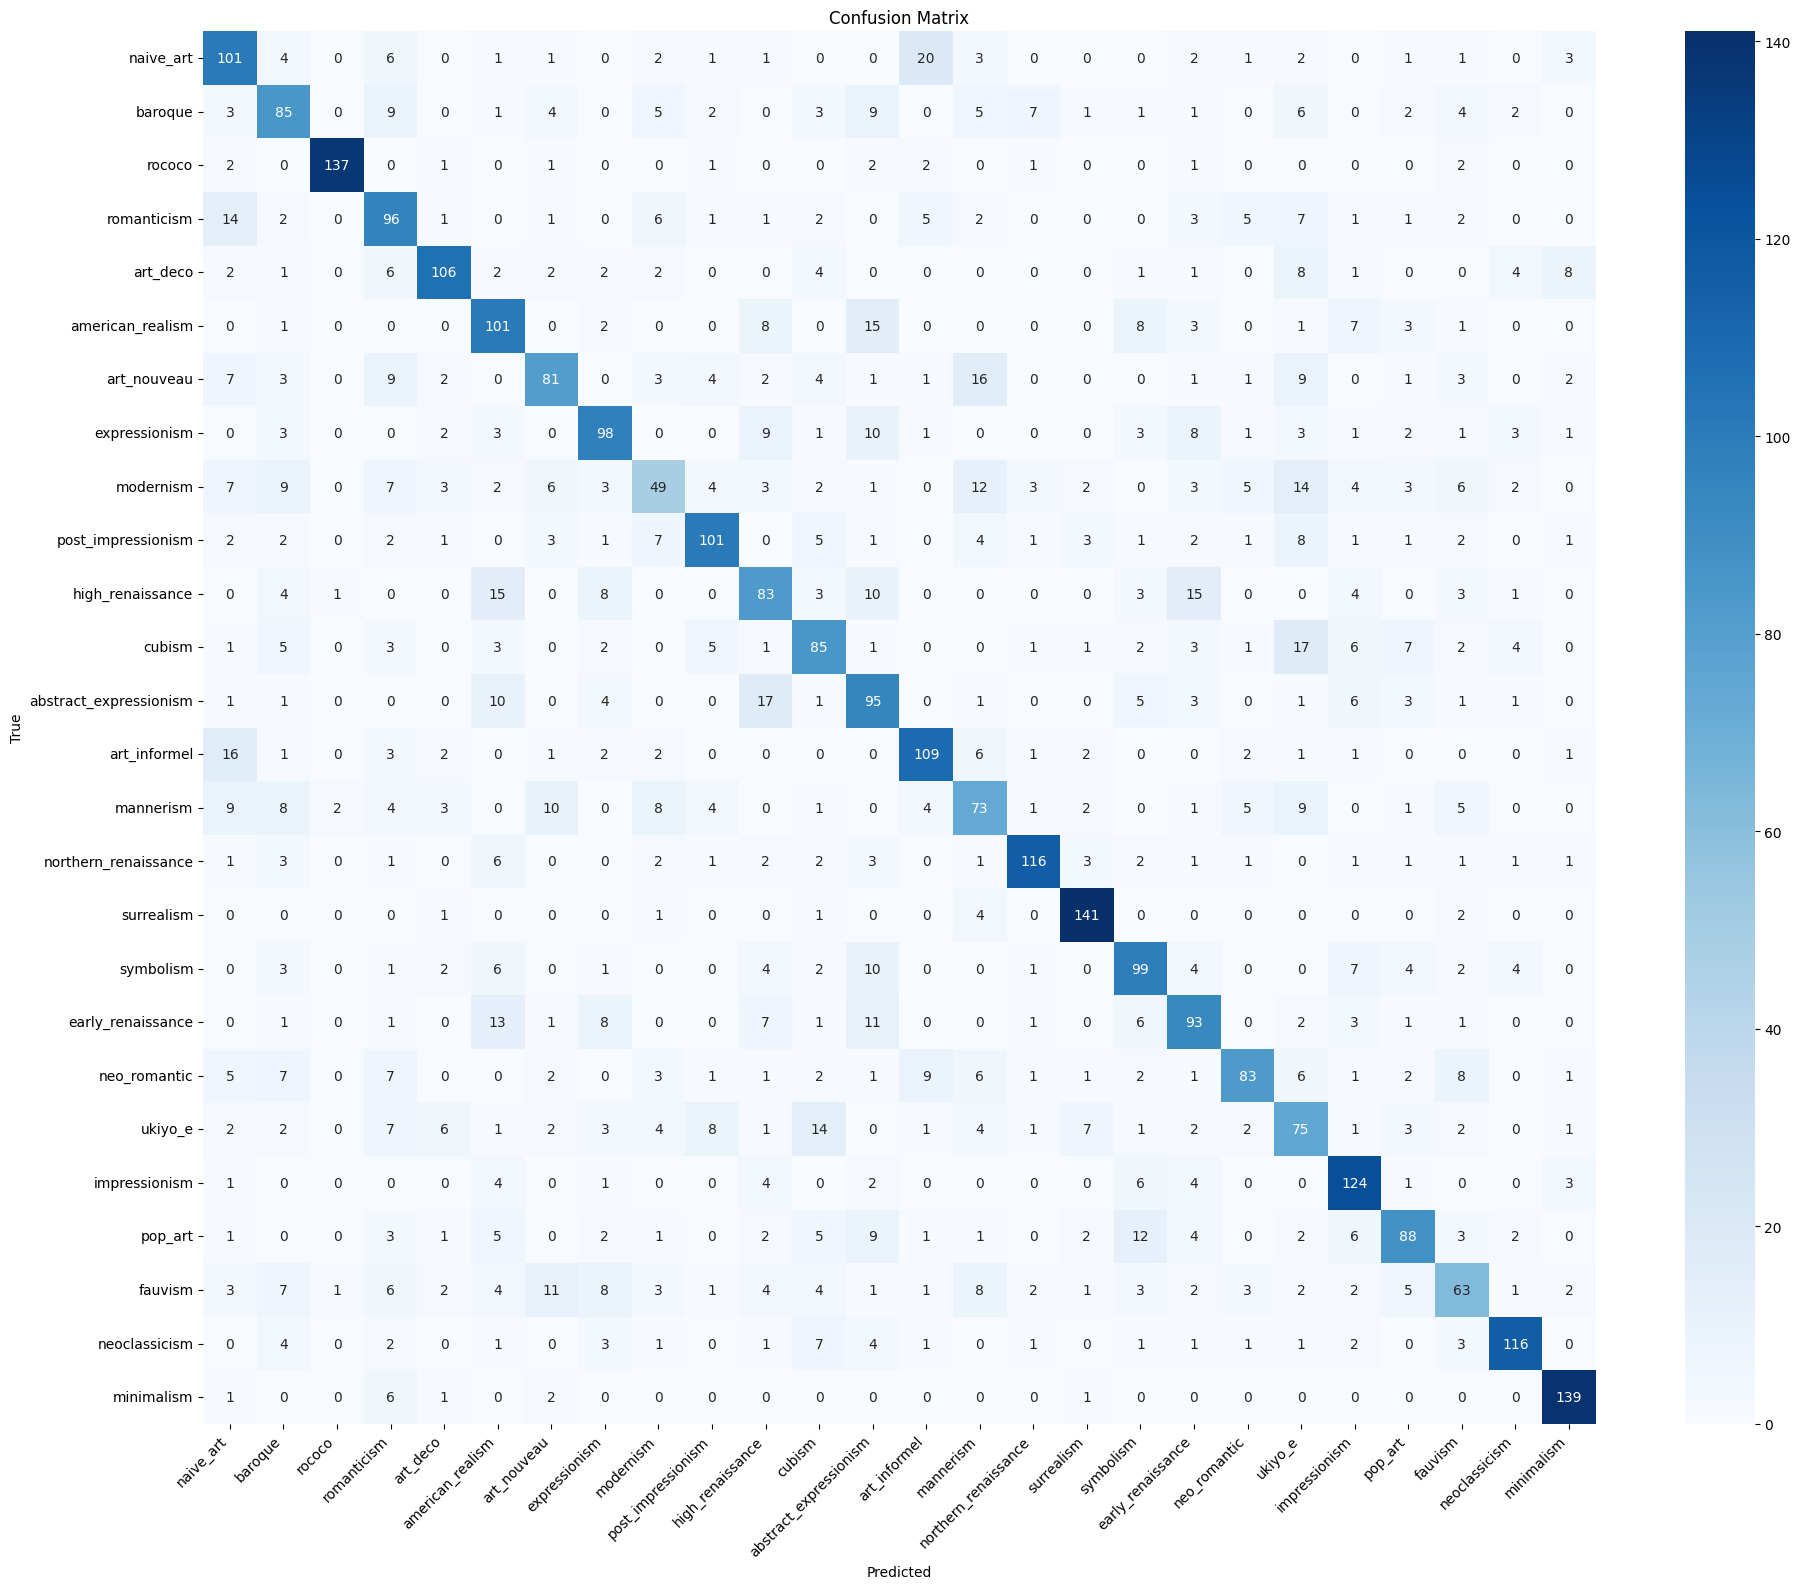

In [ ]:
# Create confusion matrix visualization
plt.figure(figsize=(20, 16))
sns.heatmap(confusion_mat,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=unique_styles,
            yticklabels=unique_styles,
            square=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

After testing and evaluating various model architectures I settled on the model with near the highest validation accuracy but with the smallest gap between train and validation accuracy, going for a model that will generalize as well as possible.

Despite the relatively low accuracy, with 26 classes the model still performs much better than random guessing


In [ ]:
# Save the model architecture and weights
model.save('/content/drive/MyDrive/art_classifier_curated.keras')

# To later load the model:
#loaded_model = keras.models.load_model('/content/drive/MyDrive/art_classifier_curated.keras')
